In [1]:
CUDA_INDEX = 0
NAME = 'Protein'
CLASSES = 3

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [14]:
model = models.NormSEDModel(8, CLASSES, 64, 64)
model.load_state_dict(torch.load(f'../runlogs/{NAME}/1621806200.6498635/best_model.pt', map_location='cpu'))

<All keys matched successfully>

In [5]:
nn_model = models.NeuralSiameseModel(8, CLASSES, 64, 64)
nn_model.load_state_dict(torch.load(f'../runlogs/{NAME}-NN/1621806408.5324519/best_model.pt', map_location='cpu'))

<All keys matched successfully>

In [6]:
dual_model = models.DualNormSEDModel(8, CLASSES, 64, 64)
dual_model.load_state_dict(torch.load(f'../runlogs/{NAME}-Dual/1622034779.064471/best_model.pt', map_location='cpu'))

<All keys matched successfully>

In [4]:
inner_test_set, _ = torch.load(f'../data/{NAME}/inner_test.pt', map_location='cpu')
inner_queries, inner_targets, _, _ = inner_test_set
nodes = [h.num_nodes for h in inner_queries]
edges = [h.num_edges for h in inner_queries]
print(f'avg query nodes: {sum(nodes)/len(nodes):.3f}')
print(f'avg query edges: {sum(edges)/len(edges):.3f}')

avg query nodes: 8.816
avg query edges: 22.086


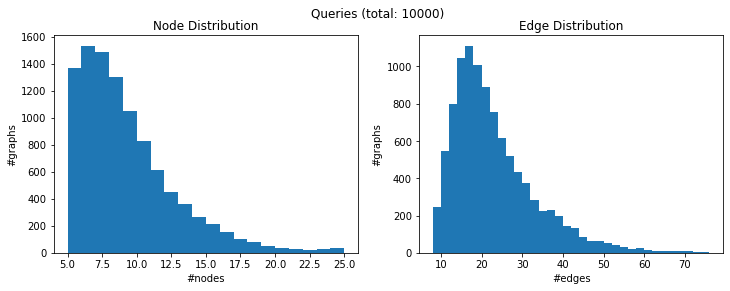

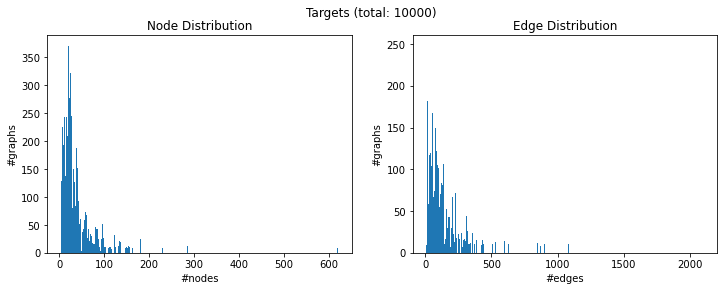

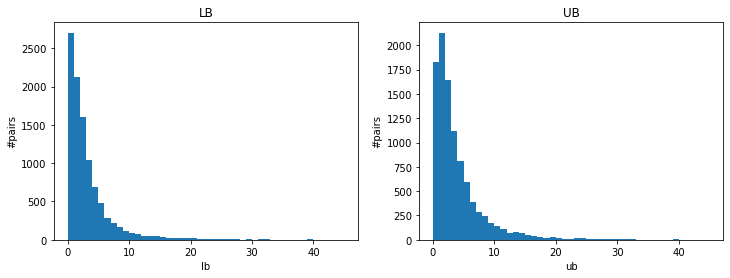

In [8]:
viz.plot_dataset_dist(inner_test_set)

In [16]:
config.n_workers = 1
tic = time.time()
inner_pred = model.predict_inner(inner_queries, inner_targets)
toc = time.time()
torch.save(inner_pred, f'../preds/{NAME}/inner_pred.pt')
print(f'NeuroGSim prediction time: {toc-tic:.3f}s')

direct predict inner dataset
NeuroGSim prediction time: 0.832s


In [13]:
tic = time.time()
nn_inner_pred = nn_model.predict_inner(inner_queries, inner_targets)
toc = time.time()
torch.save(nn_inner_pred, f'../preds/{NAME}/nn_inner_pred.pt')
print(f'NeuroGSim-NN prediction time: {toc-tic:.3f}s')

direct predict inner dataset
NeuroGSim-NN prediction time: 0.896s


In [14]:
tic = time.time()
dual_inner_pred = dual_model.predict_inner(inner_queries, inner_targets)
toc = time.time()
torch.save(dual_inner_pred, f'../preds/{NAME}/dual_inner_pred.pt')
print(f'NeuroGSim-Dual prediction time: {toc-tic:.3f}s')

direct predict inner dataset
NeuroGSim-Dual prediction time: 1.079s


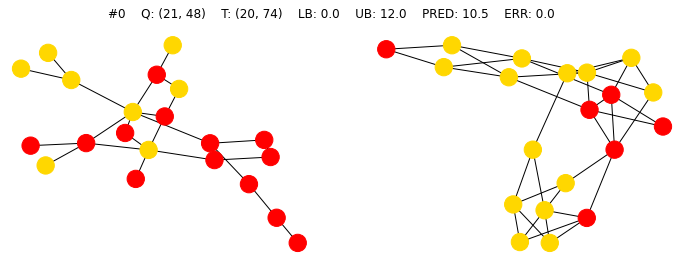

---

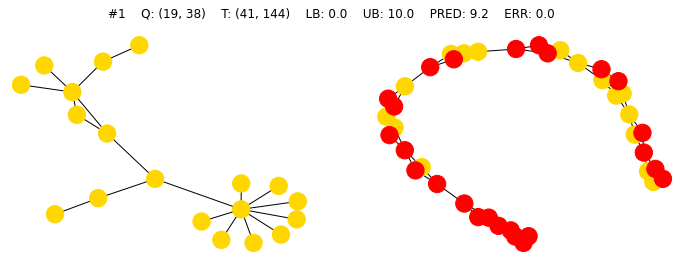

---

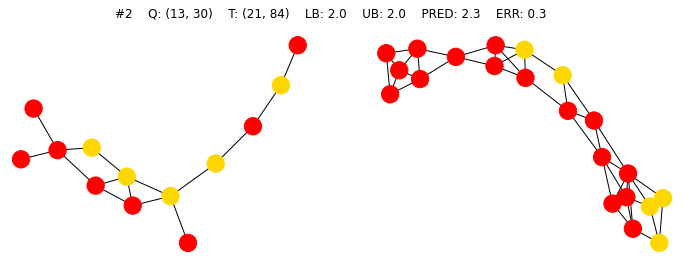

---

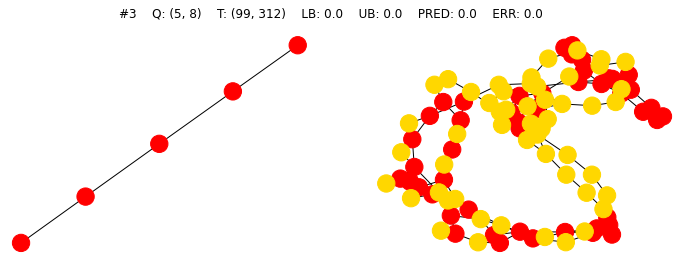

---

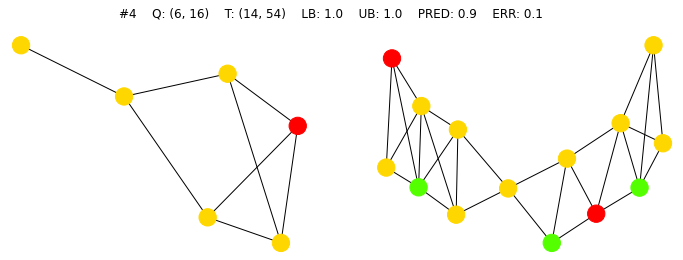

---

In [15]:
viz.plot_inner_dataset(inner_test_set, inner_pred, n_items=5)

In [5]:
config.n_workers = 1
config.method_name = ['branch']
config.method_args = ['']
tic = time.time()
b_inner_lb, b_inner_ub = datasets.inner_sed(inner_queries, inner_targets)
b_inner_pred = (b_inner_lb+b_inner_ub)/2
toc = time.time()
torch.save(b_inner_pred, f'../preds/{NAME}/b_inner_pred.pt')
print(f'Branch prediction time: {toc-tic:.3f} s ')

compute inner sed (bounds only)
n_workers: 1
method_name: ['branch']
method_args: ['']


pairs:   0%|          | 0/10000 [00:00<?, ?it/s]

Branch prediction time: 52.264 s 


In [5]:
config.n_workers = 1
config.method_name = ['f2']
config.method_args = ['--time-limit 0.1']
tic = time.time()
f2_inner_lb, f2_inner_ub = datasets.inner_sed(inner_queries, inner_targets)
f2_inner_pred = (f2_inner_lb+f2_inner_ub)/2
toc = time.time()
torch.save(f2_inner_pred, f'../preds/{NAME}/f2_inner_pred.pt')
print(f'F2 prediction time: {toc-tic:.3f} s ')

compute inner sed (bounds only)
n_workers: 1
method_name: ['f2']
method_args: ['--time-limit 0.1']


pairs:   0%|          | 0/10000 [00:00<?, ?it/s]

F2 prediction time: 881.775 s 


In [7]:
outer_test_set = torch.load(f'../data/{NAME}/outer_test.pt', map_location='cpu')
outer_queries, outer_targets, _, _ = outer_test_set

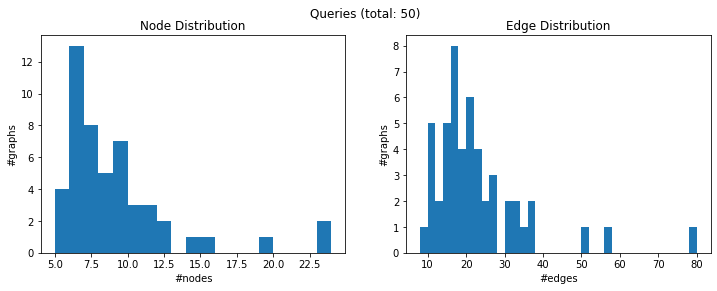

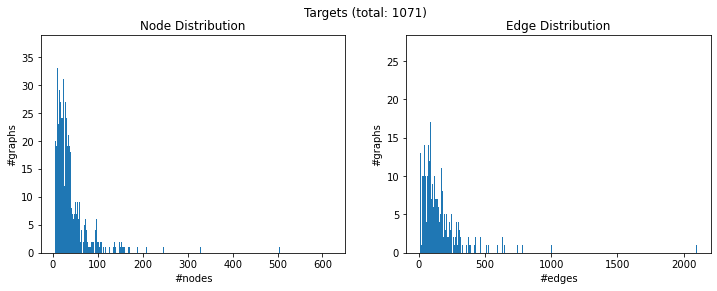

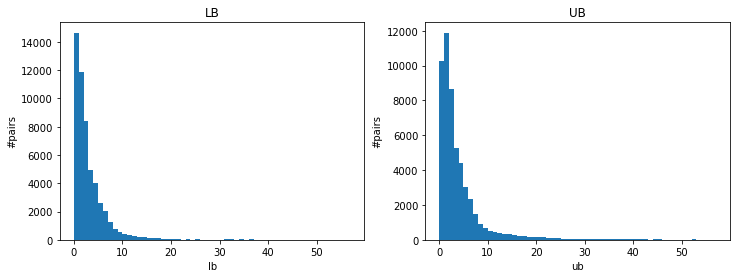

In [17]:
viz.plot_dataset_dist(outer_test_set)

In [9]:
config.n_workers=1
tic = time.time()
outer_pred = model.predict_outer(outer_queries, outer_targets, batch_size=4096)
toc = time.time()
torch.save(outer_pred, f'../preds/{NAME}/outer_pred.pt')
print(f'NeuroGSim prediction time: {toc-tic:.3f} s')

batch predict outer dataset
config.n_workers: 1


batches:   0%|          | 0/14 [00:00<?, ?it/s]

NeuroGSim prediction time: 0.359 s


In [10]:
tic = time.time()
nn_outer_pred = nn_model.predict_outer(outer_queries, outer_targets, batch_size=4096)
toc = time.time()
torch.save(nn_outer_pred, f'../preds/{NAME}/nn_outer_pred.pt')
print(f'NeuroGSim-NN prediction time: {toc-tic:.3f} s')

batch predict outer dataset
config.n_workers: 1


batches:   0%|          | 0/14 [00:00<?, ?it/s]

NeuroGSim-NN prediction time: 0.349 s


In [11]:
tic = time.time()
dual_outer_pred = dual_model.predict_outer(outer_queries, outer_targets, batch_size=4096)
toc = time.time()
torch.save(dual_outer_pred, f'../preds/{NAME}/dual_outer_pred.pt')
print(f'NeuroGSim-Dual prediction time: {toc-tic:.3f} s')

batch predict outer dataset
config.n_workers: 1


batches:   0%|          | 0/14 [00:00<?, ?it/s]

NeuroGSim-Dual prediction time: 0.342 s


In [12]:
config.n_workers = 64
config.method_name = ['branch']
config.method_args = ['']
tic = time.time()
b_outer_lb, b_outer_ub = datasets.outer_sed(outer_queries, outer_targets)
b_outer_pred = (b_outer_lb + b_outer_ub)/2
toc = time.time()
torch.save(b_outer_pred, f'../preds/{NAME}/b_outer_pred.pt')
print(f'Branch prediction time: {toc-tic:.3f} s')

compute outer sed
n_workers: 64
method_name: ['branch']
method_args: ['']


pairs:   0%|          | 0/53550 [00:00<?, ?it/s]

Branch prediction time: 13.888 s


In [13]:
config.n_workers = 64
config.method_name = ['f2']
config.method_args = ['--time-limit 0.1']
tic = time.time()
f2_outer_lb, f2_outer_ub = datasets.outer_sed(outer_queries, outer_targets)
f2_outer_pred = (f2_outer_lb + f2_outer_ub)/2
toc = time.time()
torch.save(f2_outer_pred, f'../preds/{NAME}/f2_outer_pred.pt')
print(f'F2 prediction time: {toc-tic:.3f} s')

compute outer sed
n_workers: 64
method_name: ['f2']
method_args: ['--time-limit 0.1']


pairs:   0%|          | 0/53550 [00:00<?, ?it/s]

F2 prediction time: 96.092 s
